In [13]:
from datascience import *
from urllib.request import urlopen
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", palette="Set2")
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [14]:
df = pd.read_csv("subtyped_data")

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (7,8,9,36,38,51,52,53,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
unique_patient_subtypes = {"Patient ID":[],"Subtype":[], "Survival Status":[]}
for i in df.iloc[1:].iterrows():
    if i[1]["#Patient Identifier"] not in unique_patient_subtypes["Patient ID"]:
        unique_patient_subtypes["Patient ID"].append(i[1]["#Patient Identifier"])
        unique_patient_subtypes["Subtype"].append(i[1]["Subtype"])
        unique_patient_subtypes["Survival Status"].append(i[1]["Overall Survival Status"])
unique_patients = pd.DataFrame(unique_patient_subtypes)

<AxesSubplot:xlabel='Subtype', ylabel='count'>

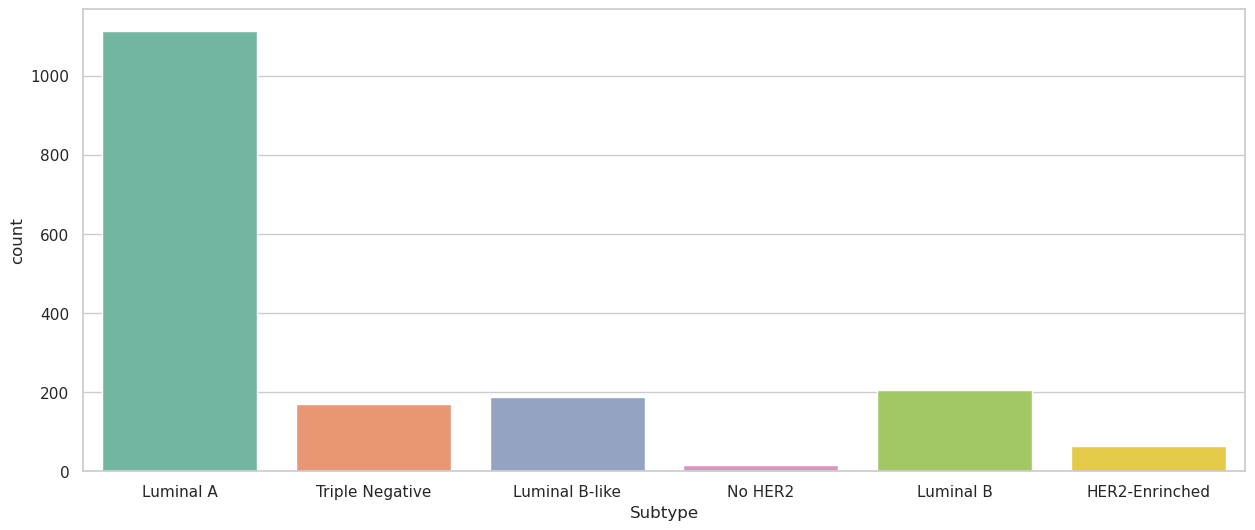

In [22]:
#get an idea of over all subtype distribution
fig,ax = plt.subplots(figsize=(15,6))
sns.countplot(data = unique_patients, x = "Subtype")

<AxesSubplot:xlabel='Variant_Classification', ylabel='count'>

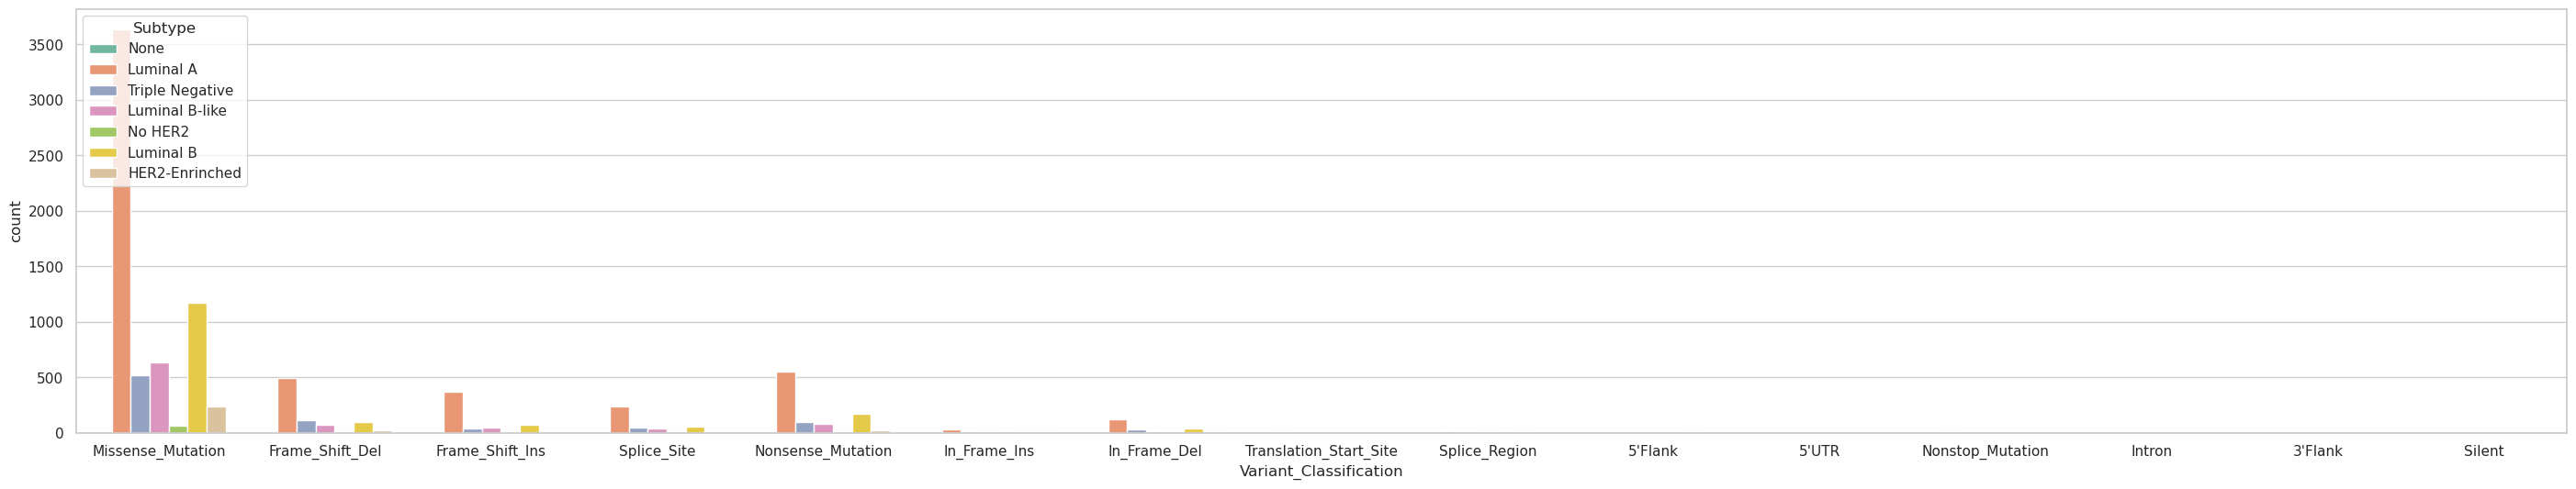

In [4]:
#get an understanding of what types of mutations are featured and the subtypes associated
fig,ax = plt.subplots(figsize=(35,6))
sns.countplot(data = df, x = "Variant_Classification", hue = "Subtype")

<AxesSubplot:xlabel='Variant_Classification', ylabel='count'>

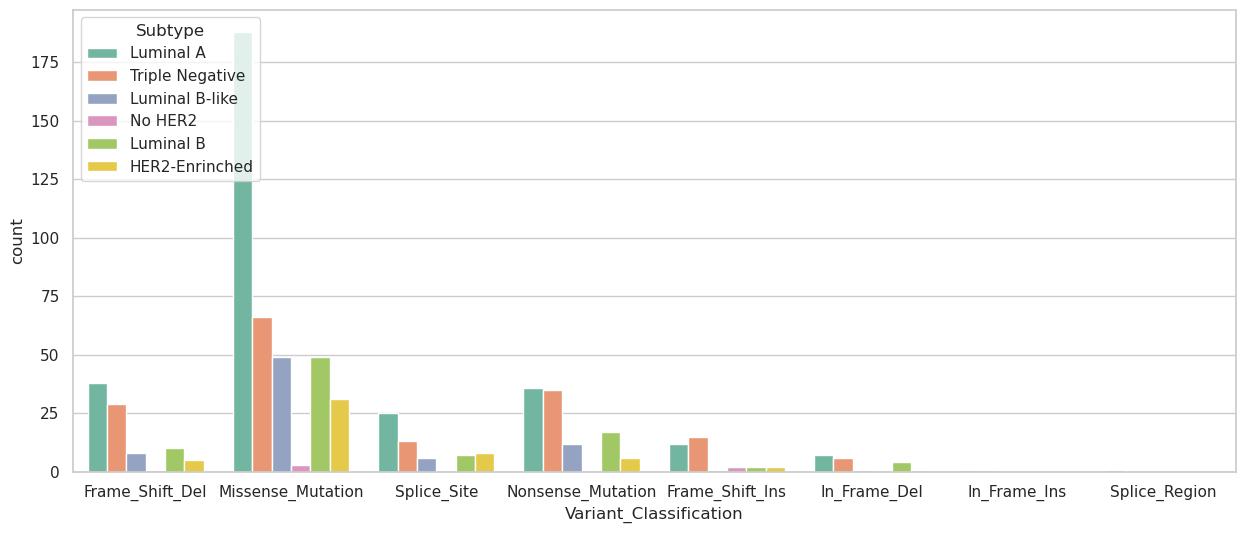

In [5]:
#above but withint TP53 mutaitons only
fig,ax = plt.subplots(figsize=(15,6))
sns.countplot(data = df.query('Hugo_Symbol == "TP53"'), x ="Variant_Classification", hue = "Subtype")

<AxesSubplot:xlabel='Subtype', ylabel='count'>

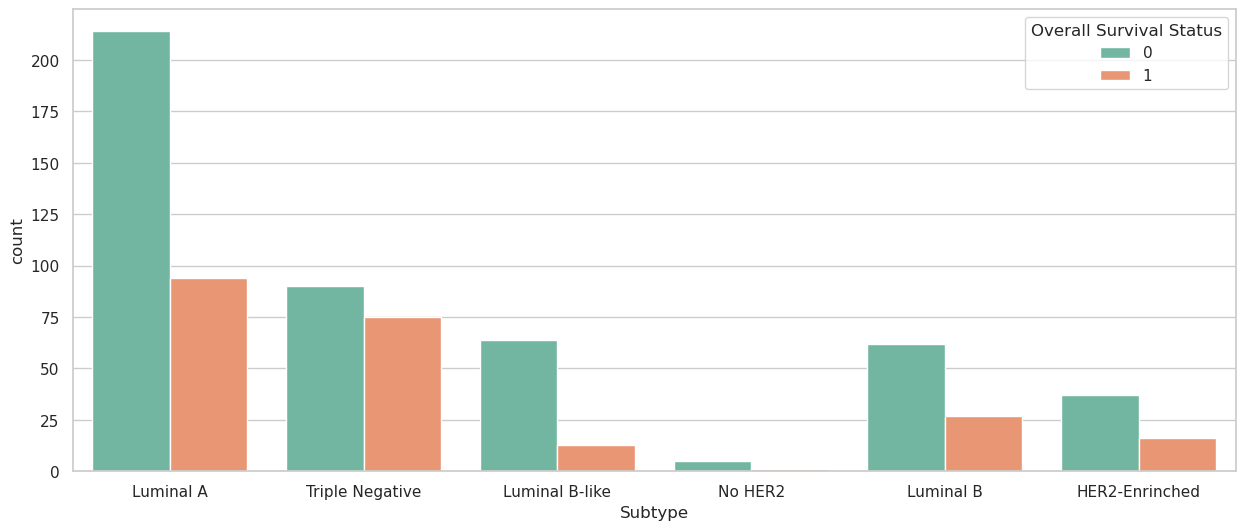

In [6]:
#survival status among subtypes for patients with TP53 mutations
fig,ax = plt.subplots(figsize=(15,6))
#0 is alive
sns.countplot(data = df.query('Hugo_Symbol == "TP53"'), x = "Subtype", hue = "Overall Survival Status")

<AxesSubplot:xlabel='Subtype', ylabel='count'>

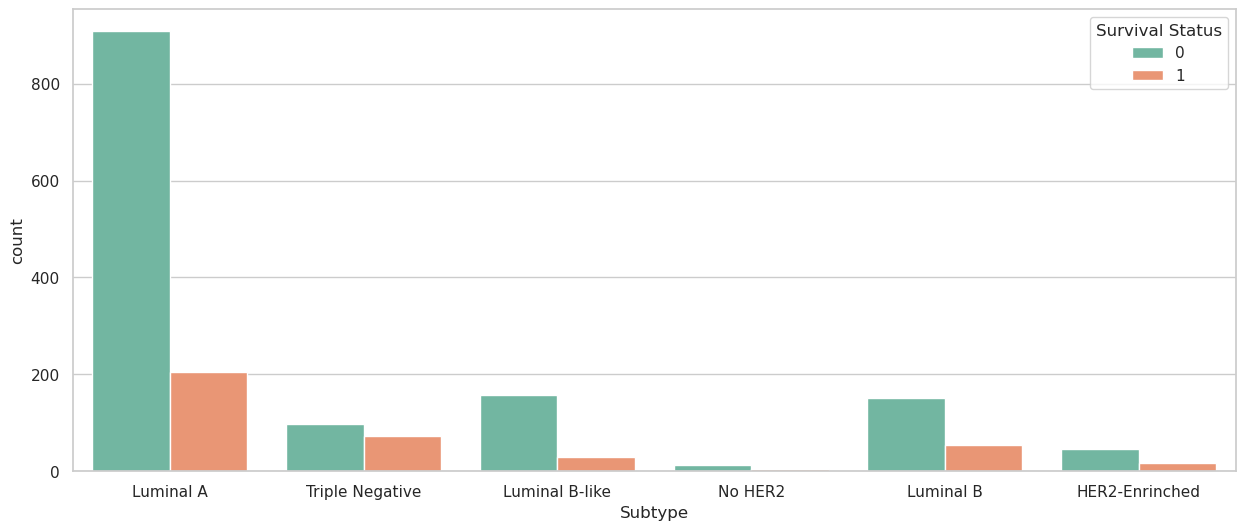

In [24]:
#survival status among subtypes for patients overall
fig,ax = plt.subplots(figsize=(15,6))
#0 is alive
sns.countplot(data = unique_patients, x = "Subtype", hue = "Survival Status")

In [9]:
#dataframe with only patients/samples with the TP53 mutation
tp53 = df.query('Hugo_Symbol == "TP53"')
tp53 = tp53.iloc[:, 2:]
huh = tp53.dropna(subset = ["Protein_position"])

/tmp/ipykernel_24/599736737.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  huh["Overall Survival (Months)"] = huh["Overall Survival (Months)"].astype(float)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify th

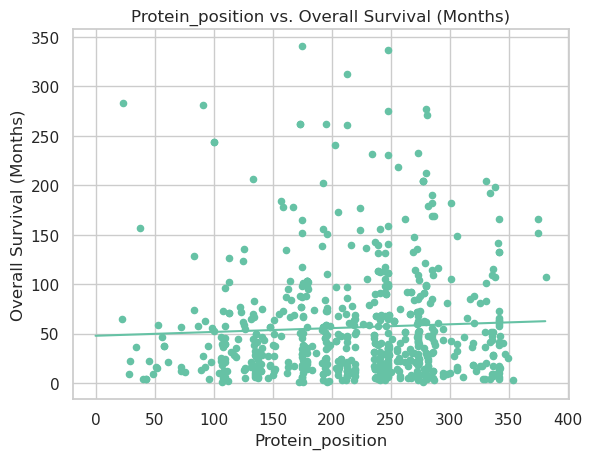

In [37]:
#seeing if protein position has any association with overall survival months
from sklearn.model_selection import train_test_split
from math import exp
#from sklearn.linear_model import LogisticRegressionlinear_model = LinearRegression(fit_intercept = True)
from sklearn.linear_model import LinearRegression

huh["Overall Survival (Months)"] = huh["Overall Survival (Months)"].astype(float)

# Train, test split
pp_train, pp_test = train_test_split(huh, 
                                       test_size = .2, 
                                       random_state = 0) 

# Train, validation split
pp_train, pp_validation = train_test_split(huh, 
                                             test_size = .25, 
                                             random_state = 0)

X_train = np.asmatrix(huh[['Protein_position']])
y_train = np.array(huh['Overall Survival (Months)'])

X_val = np.asmatrix(pp_validation[['Protein_position']])
y_val = np.array(pp_validation['Overall Survival (Months)'])

X_test = np.asmatrix(pp_test[['Protein_position']])


linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

x = np.arange(max(huh['Protein_position'])).reshape(-1, 1) # a 2D array of integers between 0 and the maximum value of the x_name column
y = linear_model.predict(x)
    
huh.plot.scatter('Protein_position','Overall Survival (Months)') # scatter plot of x_name vs. y_name
plt.plot(x,y)
plt.title('Protein_position' + " vs. " + 'Overall Survival (Months)')
plt.show()

/tmp/ipykernel_24/104729048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_samples_with_patients_wTP53["Overall Survival (Months)"] = all_samples_with_patients_wTP53["Overall Survival (Months)"].astype(float)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Num_Mutations', ylabel='Overall Survival (Months)'>

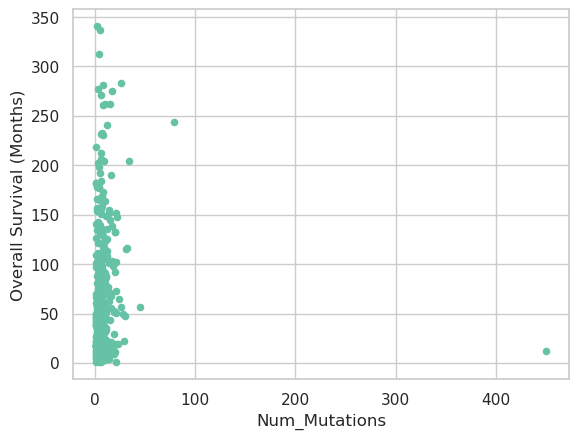

In [55]:
#Only for patients with TP53
all_samples_with_patients_wTP53 = df[df['#Patient Identifier'].isin(tp53["#Patient Identifier"])]
all_samples_with_patients_wTP53["Overall Survival (Months)"] = all_samples_with_patients_wTP53["Overall Survival (Months)"].astype(float)
mut_count = all_samples_with_patients_wTP53.groupby(["#Patient Identifier"])["Overall Survival Status"].count()
survival = all_samples_with_patients_wTP53.groupby(["#Patient Identifier"])["Overall Survival Status"].sum()/mut_count
survival_months = all_samples_with_patients_wTP53.groupby(["#Patient Identifier"])["Overall Survival (Months)"].sum()/mut_count

numMutations_and_SS = pd.DataFrame({"Num_Mutations":mut_count,"Survival":survival, "Overall Survival (Months)":survival_months})
numMutations_and_SS.plot.scatter(x= "Num_Mutations", y="Overall Survival (Months)")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Num_Mutations', ylabel='Overall Survival (Months)'>

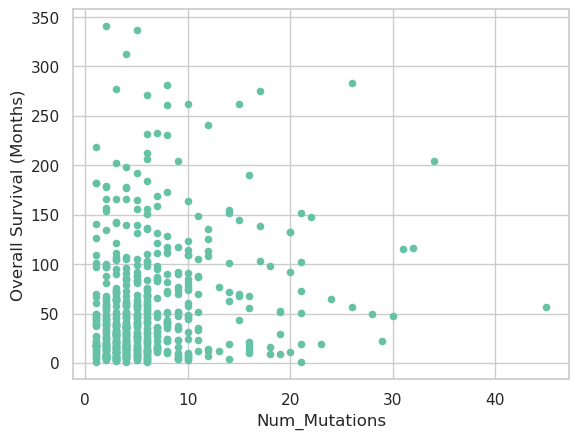

In [56]:
#drop the outliers from above
numMutations_and_SS = numMutations_and_SS.drop(index = ["P-0016773","P-0002713"])
numMutations_and_SS.plot.scatter(x= "Num_Mutations", y="Overall Survival (Months)")

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


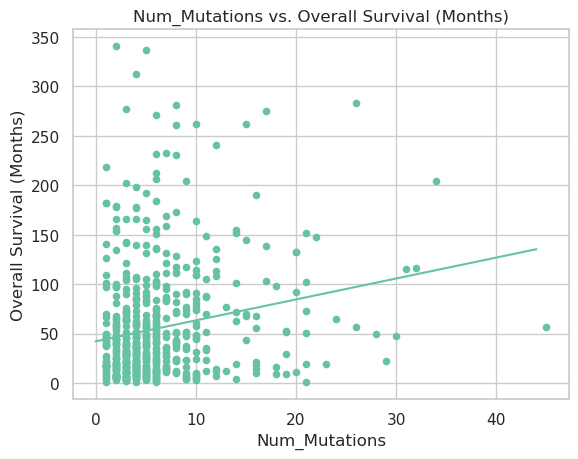

In [57]:
# Train, test split
OSM_train, OSM_test = train_test_split(numMutations_and_SS, 
                                       test_size = .2, 
                                       random_state = 0) 

# Train, validation split
OSM_train, OSM_validation = train_test_split(numMutations_and_SS, 
                                             test_size = .25, 
                                             random_state = 0)

X_train = np.asmatrix(numMutations_and_SS[['Num_Mutations']])
y_train = np.array(numMutations_and_SS['Overall Survival (Months)'])

X_val = np.asmatrix(OSM_validation[['Num_Mutations']])
y_val = np.array(OSM_validation['Overall Survival (Months)'])

X_test = np.asmatrix(OSM_test[['Num_Mutations']])


linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

x = np.arange(max(numMutations_and_SS['Num_Mutations'])).reshape(-1, 1) # a 2D array of integers between 0 and the maximum value of the x_name column
y = linear_model.predict(x)
    
numMutations_and_SS.plot.scatter('Num_Mutations','Overall Survival (Months)') # scatter plot of x_name vs. y_name
plt.plot(x,y)
plt.title('Num_Mutations' + " vs. " + 'Overall Survival (Months)')
plt.show()

/tmp/ipykernel_24/1940190007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_val["Overall Survival (Months)"] = all_val["Overall Survival (Months)"].astype(float)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Num_Mutations', ylabel='Overall Survival (Months)'>

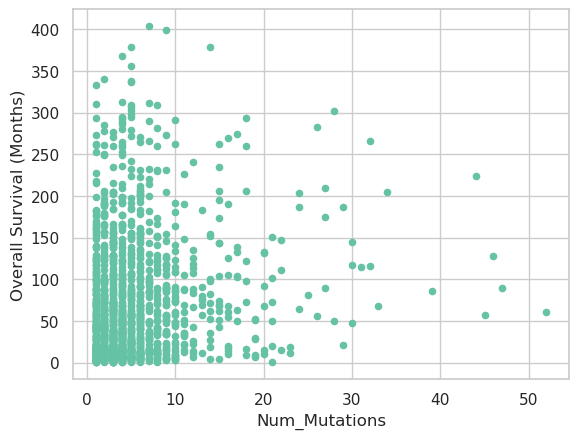

In [59]:
#OVERALL Patient mutation number versus survival
all_val = df.iloc[1:]
all_val["Overall Survival (Months)"] = all_val["Overall Survival (Months)"].astype(float)
tot_mut_count = all_val.groupby(["#Patient Identifier"])["Overall Survival Status"].count()
tot_survival = all_val.groupby(["#Patient Identifier"])["Overall Survival Status"].sum()/tot_mut_count
tot_survival_months = all_val.groupby(["#Patient Identifier"])["Overall Survival (Months)"].sum()/tot_mut_count
tot_numMutations_and_SS = pd.DataFrame({"Num_Mutations":tot_mut_count,"Survival":tot_survival, "Overall Survival (Months)":tot_survival_months})
tot_numMutations_and_SS = tot_numMutations_and_SS.drop(index = ["P-0016773","P-0002713"])
tot_numMutations_and_SS.plot.scatter(x= "Num_Mutations", y="Overall Survival (Months)")


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


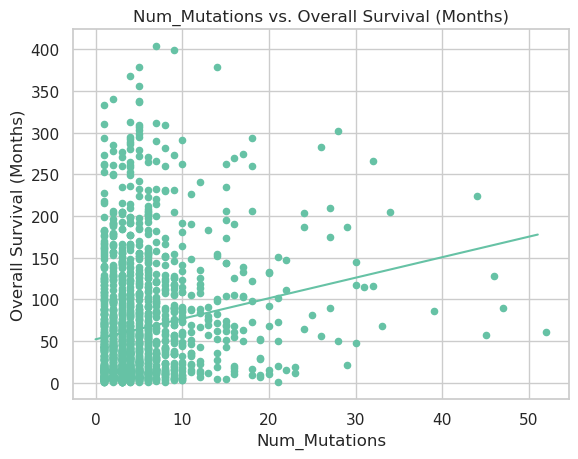

In [60]:
# Train, test split
tot_OSM_train, tot_OSM_test = train_test_split(tot_numMutations_and_SS, 
                                       test_size = .2, 
                                       random_state = 0) 

# Train, validation split
tot_OSM_train, tot_OSM_validation = train_test_split(tot_numMutations_and_SS, 
                                             test_size = .25, 
                                             random_state = 0)

X_train = np.asmatrix(tot_numMutations_and_SS[['Num_Mutations']])
y_train = np.array(tot_numMutations_and_SS['Overall Survival (Months)'])

X_val = np.asmatrix(tot_OSM_validation[['Num_Mutations']])
y_val = np.array(tot_OSM_validation['Overall Survival (Months)'])

X_test = np.asmatrix(tot_OSM_test[['Num_Mutations']])


linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

x = np.arange(max(tot_numMutations_and_SS['Num_Mutations'])).reshape(-1, 1) # a 2D array of integers between 0 and the maximum value of the x_name column
y = linear_model.predict(x)
    
tot_numMutations_and_SS.plot.scatter('Num_Mutations','Overall Survival (Months)') # scatter plot of x_name vs. y_name
plt.plot(x,y)
plt.title('Num_Mutations' + " vs. " + 'Overall Survival (Months)')
plt.show()

In [61]:
group_symbol = df.groupby(["Hugo_Symbol"]).count().sort_values("Unnamed: 0", ascending = False).iloc[0:11]
most_index = group_symbol.index

In [11]:
most_popular = df[df['Hugo_Symbol'].isin(most_index)]

In [12]:
survival_percentage = (most_popular.groupby(["Hugo_Symbol", "Overall Survival Status"]).count()/most_popular.groupby(["Hugo_Symbol"]).count())[["#Patient Identifier"]]
survival_percentage.reset_index(inplace=True)

In [13]:
temp = {"Hugo_Symbol":[], "Alive Percent":[], "Dead Percent":[]}
x = 0
for i in survival_percentage.iterrows(): 
    if x == 0:
        temp["Hugo_Symbol"].append(i[1][0])
        temp["Alive Percent"].append(i[1][2])
        x = x + 1
    else:
        temp["Dead Percent"].append(i[1][2])
        x = x-1

In [14]:
survival_percentage = pd.DataFrame(temp)
survival_percentage

,Hugo_Symbol,Alive Percent,Dead Percent
0,AKT1,0.733945,0.266055
1,ARID1A,0.752212,0.247788
2,CDH1,0.801917,0.198083
3,ESR1,0.708571,0.291429
4,GATA3,0.862416,0.137584
5,MAP3K1,0.861607,0.138393
6,MLL3,0.718121,0.281879
7,PIK3CA,0.791768,0.208232
8,PTEN,0.761290,0.238710
9,TBX3,0.885714,0.114286


<AxesSubplot:title={'center':'Stacked Bar Graph'}, ylabel='Hugo_Symbol'>

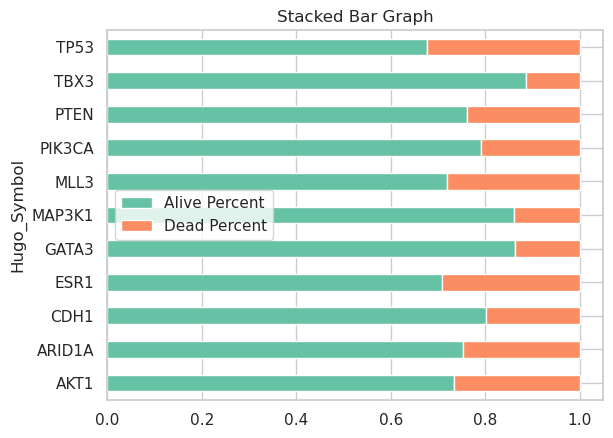

In [19]:
survival_percentage.plot(
    x = 'Hugo_Symbol',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph')